In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torch.optim as optim
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dirve_path = '/content/drive/MyDrive/Project/'
train = pd.read_csv(dirve_path + 'security_train.csv')

In [ ]:
print(train.isnull().sum())

In [ ]:
df = train

Label

In [ ]:
label_counts = train['label'].value_counts().sort_index()

In [ ]:
label_map = {
    0: 'Normal',
    1: 'Ransom',
    2: 'Miner',
    3: 'DDoS',
    4: 'Worm',
    5: 'Virus',
    6: 'Backdoor',
    7: 'Trojan'
}

label_counts.index = label_counts.index.map(label_map)

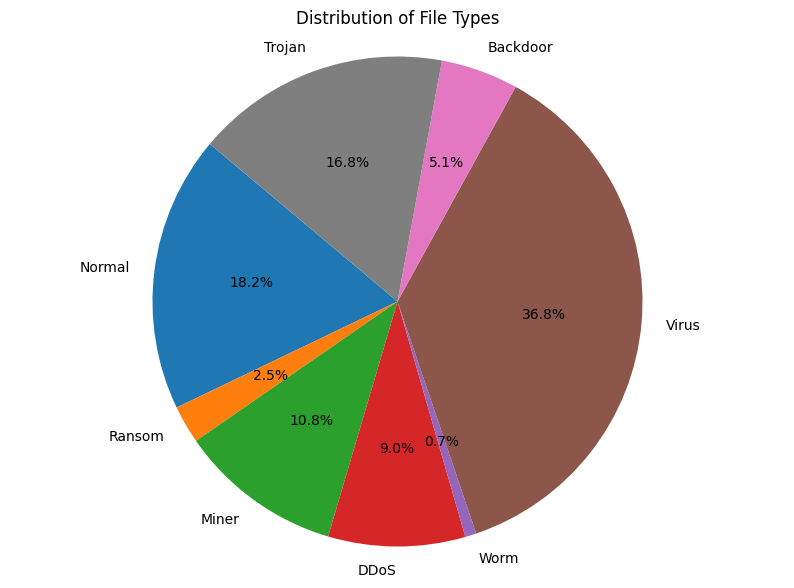

In [ ]:
plt.figure(figsize=(10, 7))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of File Types')
plt.axis('equal')
plt.show()

API

In [ ]:
N = 30
api_counts = train['api'].value_counts().head(N)

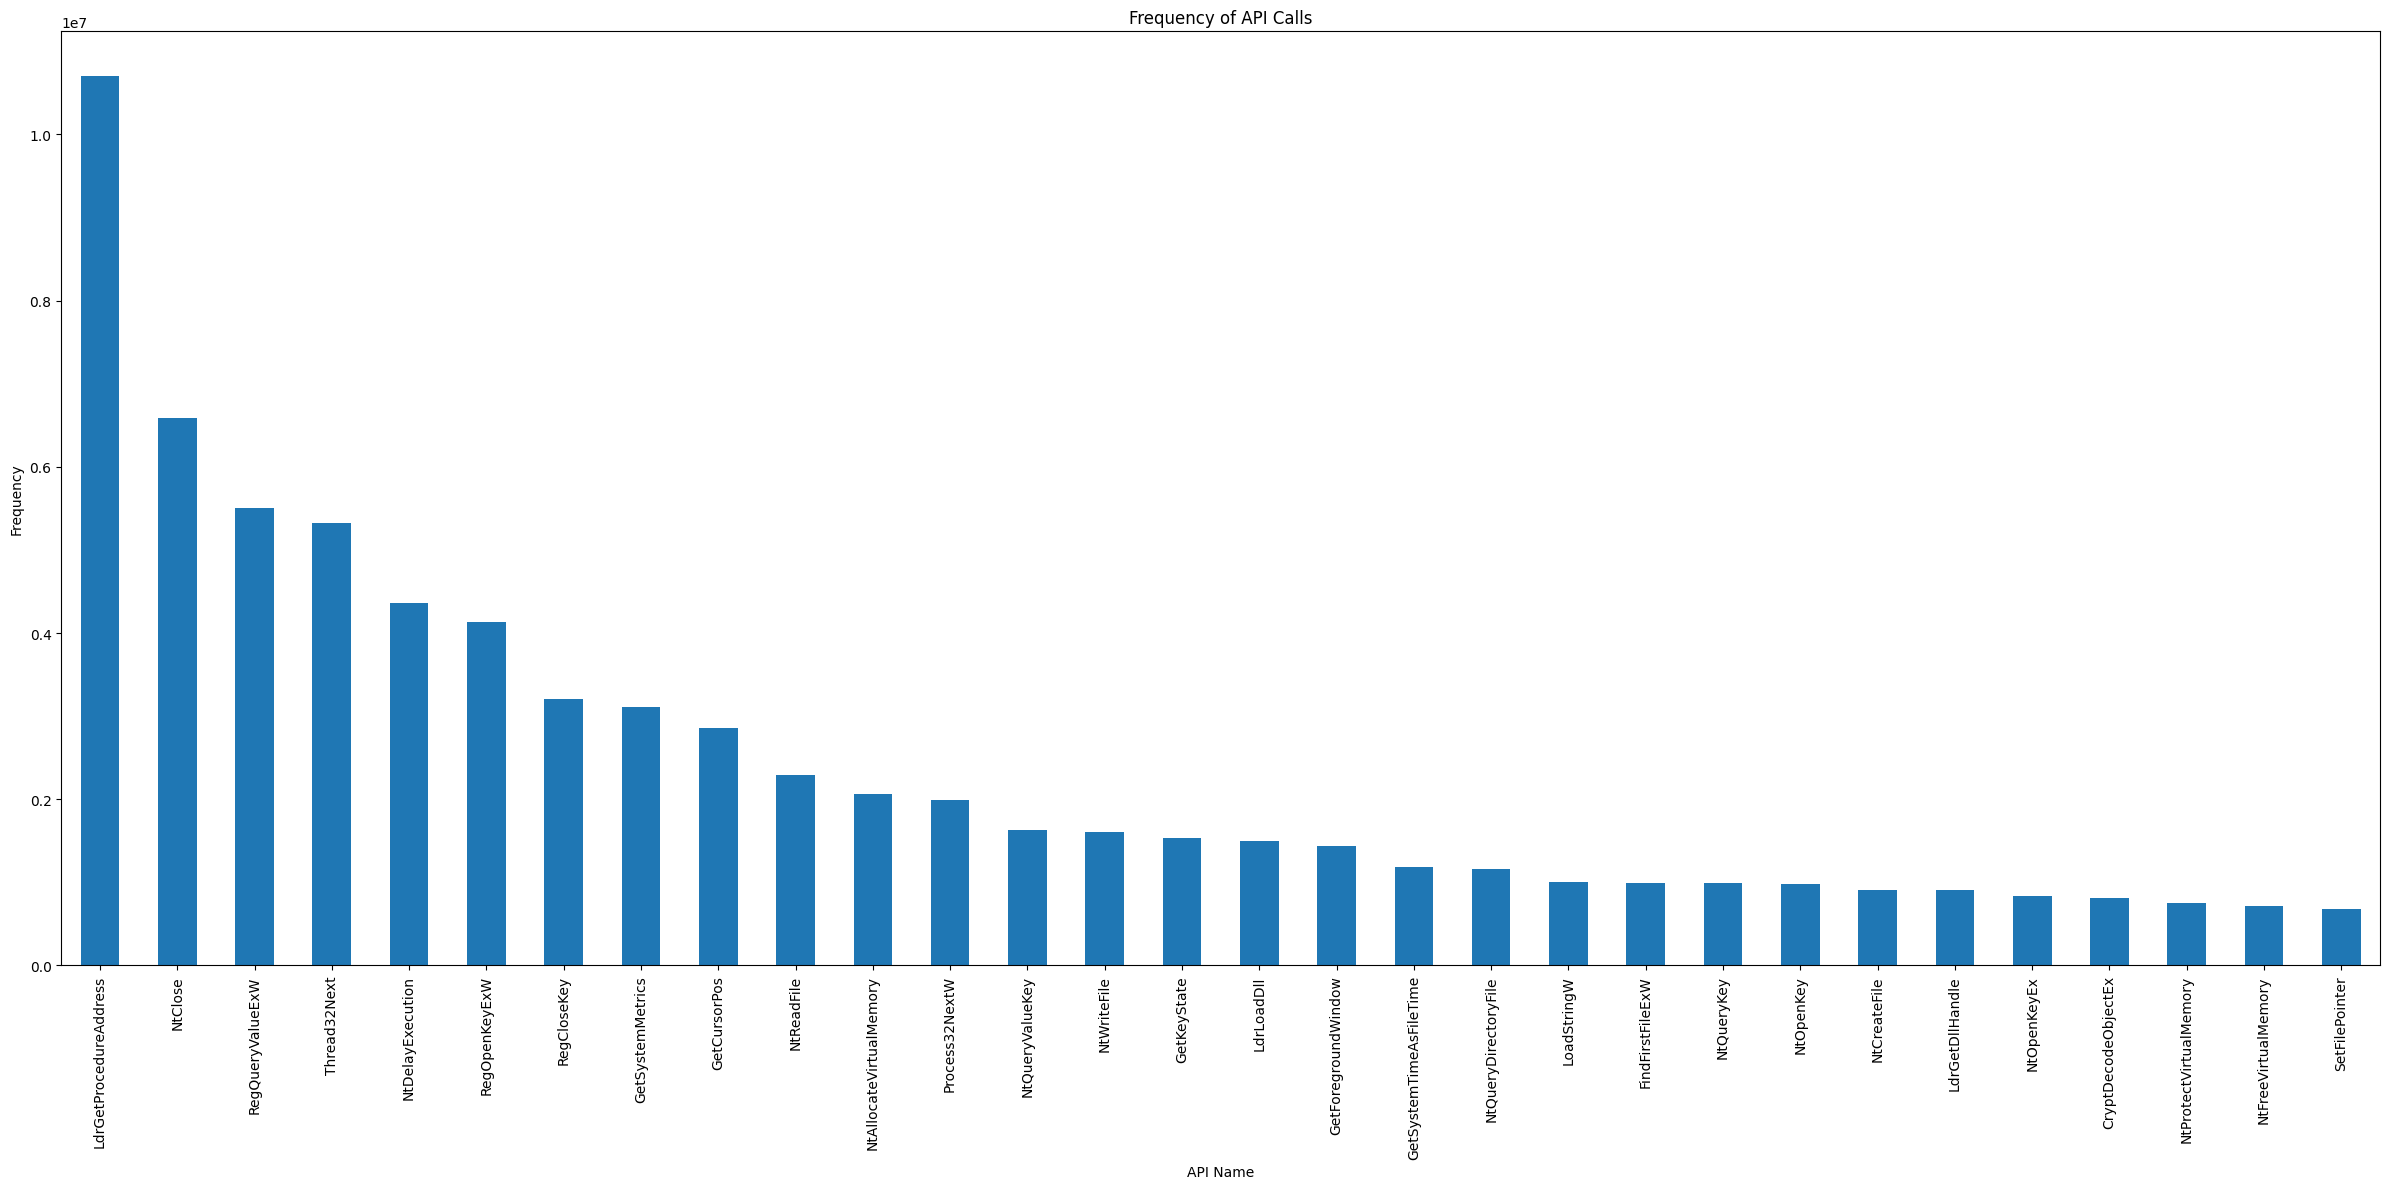

In [ ]:
plt.figure(figsize=(24,12))
api_counts.plot(kind = 'bar')

plt.title('Frequency of API Calls')
plt.xlabel('API Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Thread

In [ ]:
tid_counts = train.groupby('tid').count()['api']

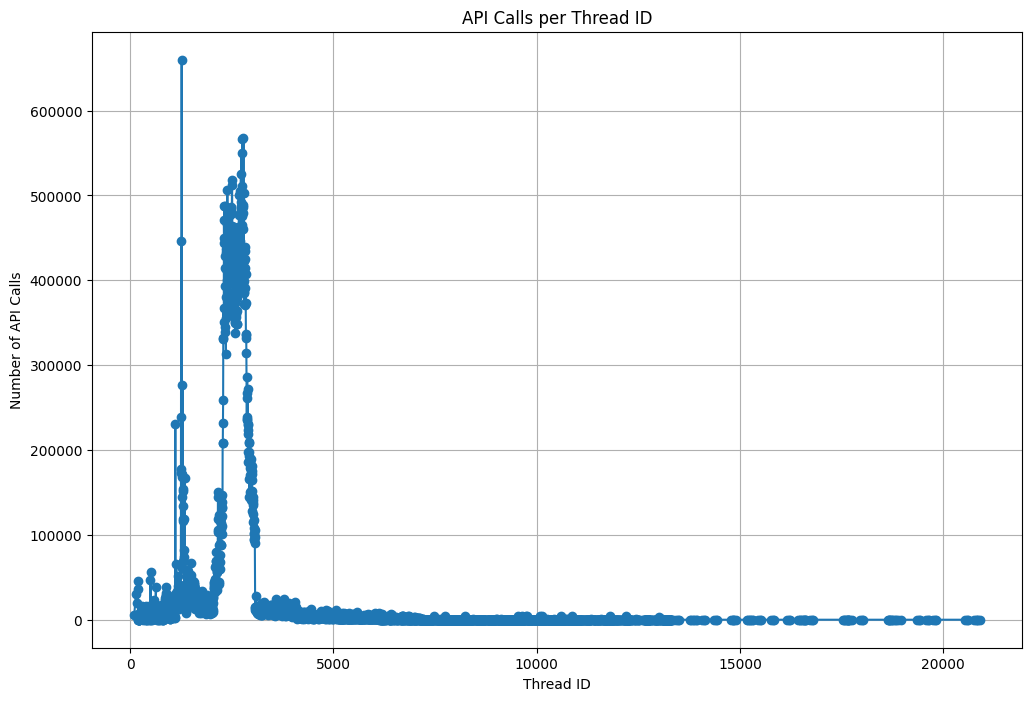

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(tid_counts.index, tid_counts.values, marker = 'o', linestyle = '-')
plt.title('API Calls per Thread ID')
plt.xlabel('Thread ID')
plt.ylabel('Number of API Calls')
plt.grid(True)
plt.show()

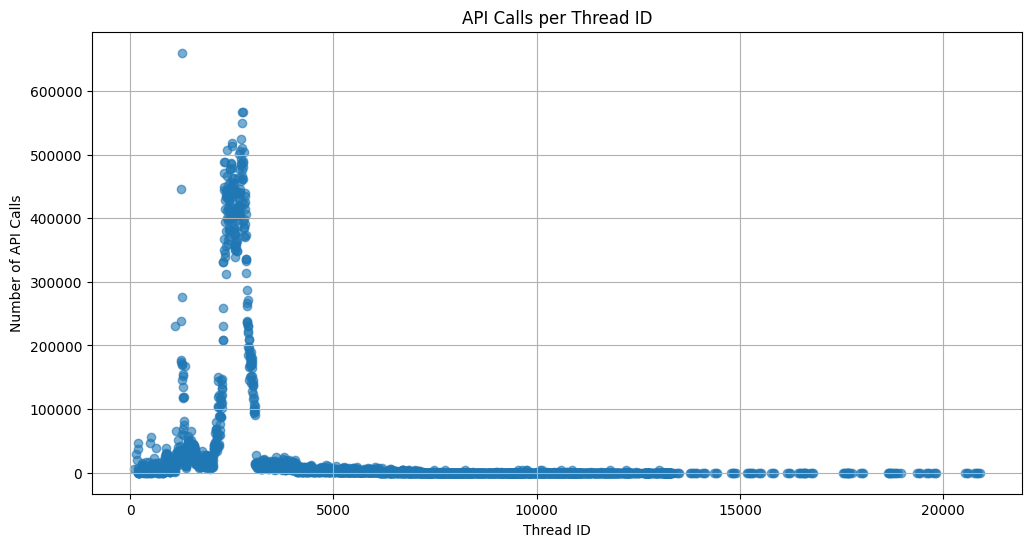

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(tid_counts.index, tid_counts.values, alpha=0.6)
plt.title('API Calls per Thread ID')
plt.xlabel('Thread ID')
plt.ylabel('Number of API Calls')
plt.grid(True)
plt.show()

Distribution of the number of API calls for different malware types

In [ ]:
train['label'] = train['label'].astype('category')
grouped = train.groupby('label')['api'].count().reset_index(name='api_count')

<ipython-input-15-3a3a7621fe50>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train.groupby('label')['api'].count().reset_index(name='api_count')


In [ ]:
label_map = {
    0: 'Normal',
    1: 'Ransom',
    2: 'Miner',
    3: 'DDoS',
    4: 'Worm',
    5: 'Virus',
    6: 'Backdoor',
    7: 'Trojan'
}
grouped['label'] = grouped['label'].map(label_map)

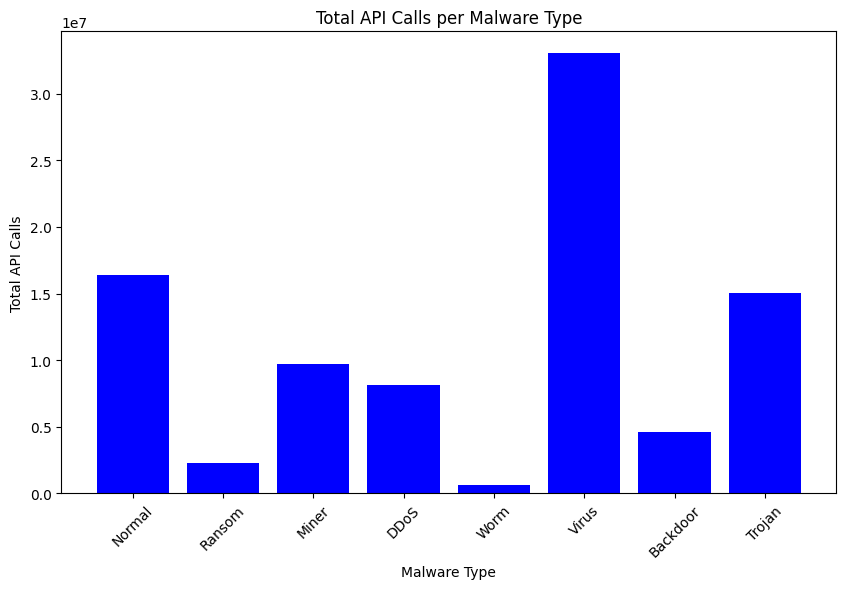

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(grouped['label'], grouped['api_count'], color='blue')
plt.xlabel('Malware Type')
plt.ylabel('Total API Calls')
plt.title('Total API Calls per Malware Type')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df = train

In [ ]:
api_calls_per_malware_type = df.groupby(['label', 'file_id'])['api'].count().reset_index(name='api_count')

<ipython-input-35-9bb2970a7e36>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  api_calls_per_malware_type = df.groupby(['label', 'file_id'])['api'].count().reset_index(name='api_count')


In [ ]:
api_calls_per_malware_type['label'] = api_calls_per_malware_type['label'].map(label_map)

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='api_count', data=api_calls_per_malware_type)
plt.title('Distribution of API Calls per Malware Type for Each Instance')
plt.xlabel('Malware Type')
plt.ylabel('API Calls Count')
plt.show()

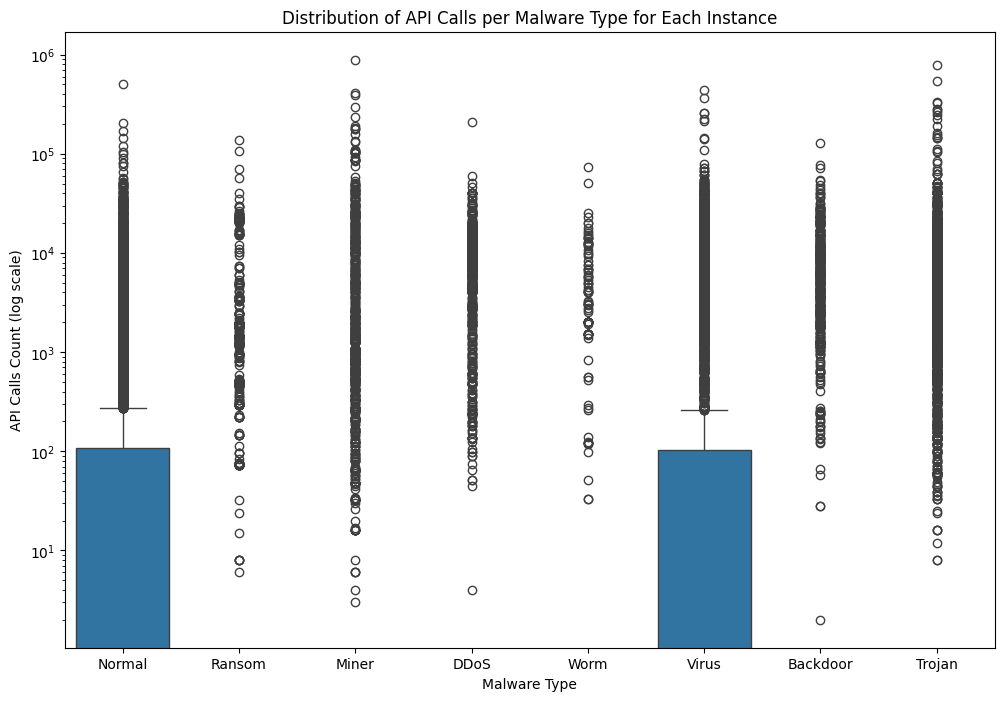

In [ ]:
plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x='label', y='api_count', data=api_calls_per_malware_type)

boxplot.set_yscale('log')  # Logarithmic scale
boxplot.set_title('Distribution of API Calls per Malware Type for Each Instance')
boxplot.set_xlabel('Malware Type')
boxplot.set_ylabel('API Calls Count (log scale)')
plt.show()


The time sequence of API calls:

Timeline or sequence plots: although the dataset does not maintain sequential integrity across threads, the index field maintains the order of API calls within a single thread (tid). Plotting these sequences can help identify typical patterns of API calls in a thread, which may be characteristic of malicious behaviour.

In [ ]:
df_sorted = df.sort_values(['tid','index'])
# Using .loc to securely create new columns
#df_thread.loc[:, 'api_short'] = df_thread['api'].apply(lambda x: x[:5])

In [ ]:
df_sorted['api_short'] = df_sorted['api'].apply(lambda x: x[:3])
#Calculate the number of API calls per thread
api_counts  = df.groupby('tid').size().reset_index(name='counts')
top_threads = api_counts.nlargest(1, 'counts')['tid']

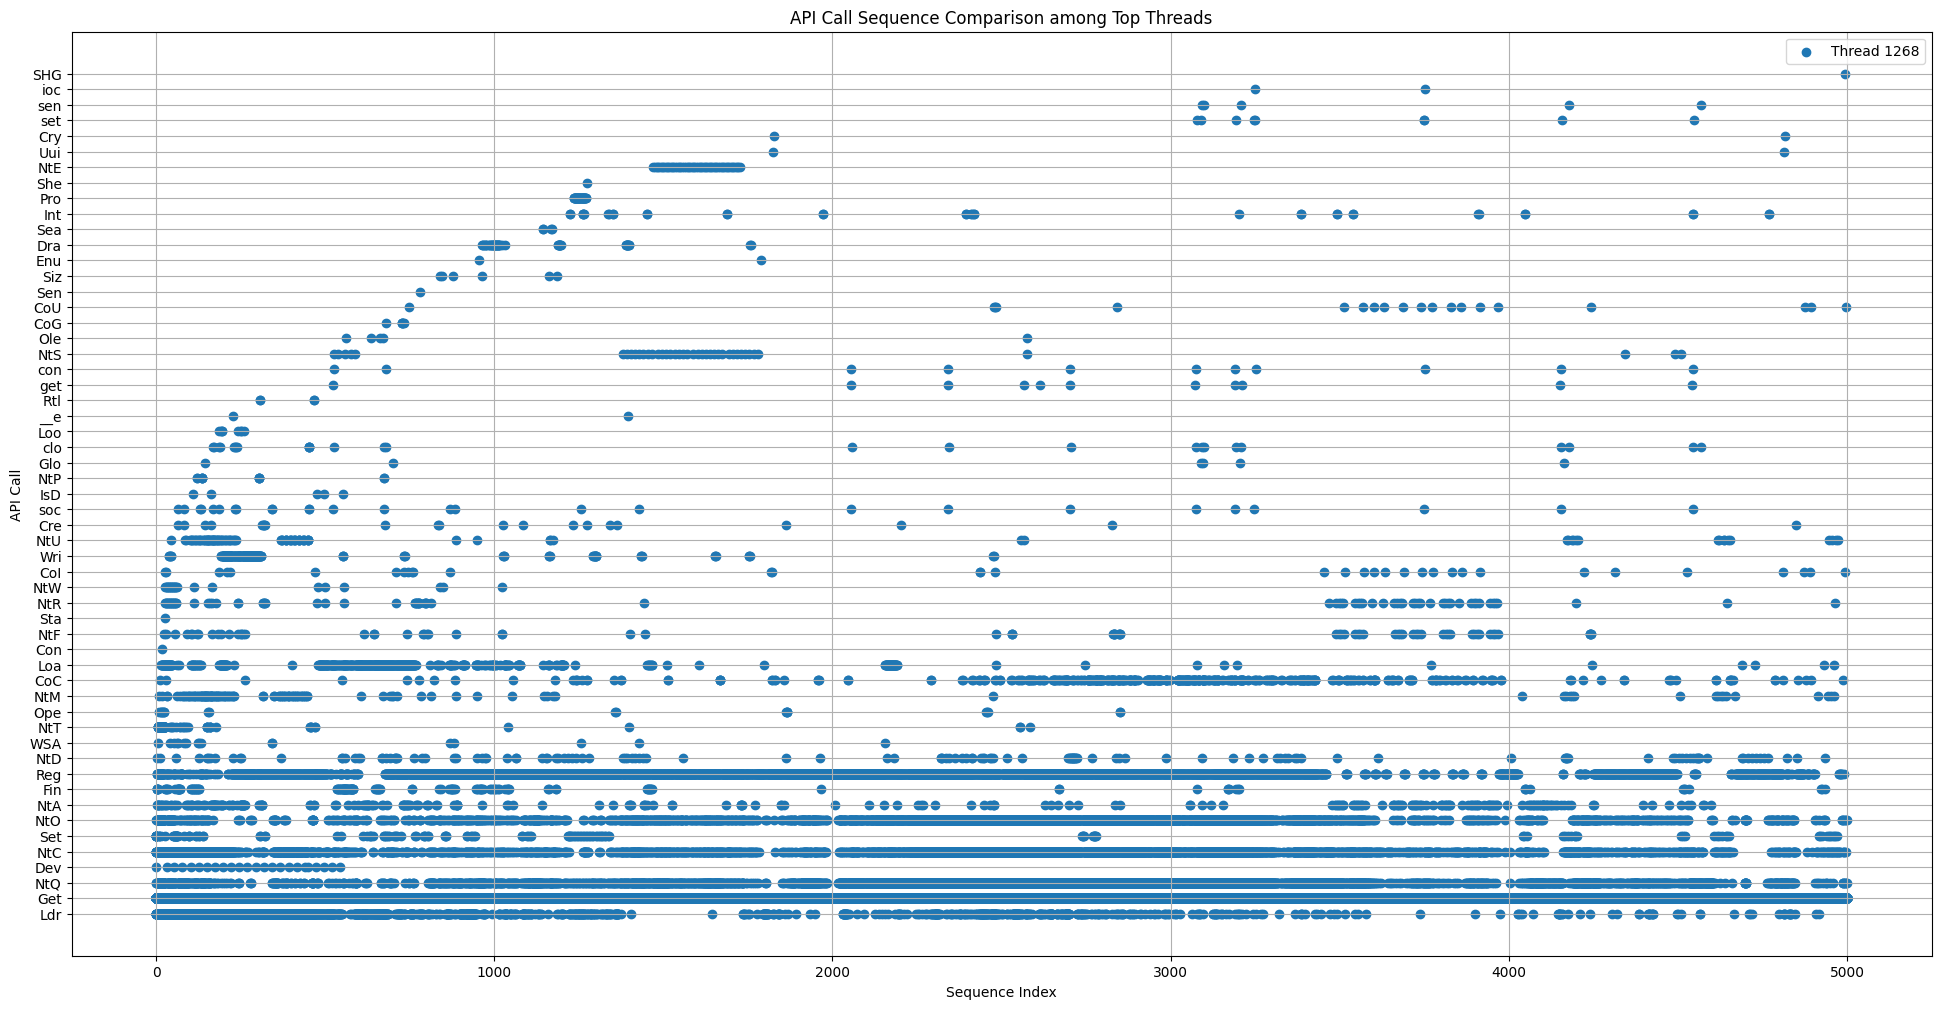

In [ ]:
plt.figure(figsize=(24, 12))

# Iterate over the selected threads and plot their API call sequences
for tid in top_threads:
    df_thread = df_sorted[df_sorted['tid'] == tid]
    plt.scatter(df_thread['index'], df_thread['api_short'], label=f'Thread {tid}')
#This axis shows the order of each API call in the thread.
#For example, sequence number 0 indicates the first API call, sequence number 1000 indicates the 1001st API call, and so on.
plt.title('API Call Sequence')
plt.xlabel('Sequence Index')
plt.ylabel('API Call')
plt.legend()  # Add legend
plt.grid(True)
plt.show()

In [ ]:

apis = df['api'].unique()
co_occurrence_matrix = pd.DataFrame(data=np.zeros((len(apis), len(apis))), index=apis, columns=apis)

for _, group in df.groupby(['file_id', 'tid']):  # Grouping based on files and threads
    unique_apis = group['api'].unique()
    for i in range(len(unique_apis)):
        for j in range(i+1, len(unique_apis)):
            co_occurrence_matrix.at[unique_apis[i], unique_apis[j]] += 1
            co_occurrence_matrix.at[unique_apis[j], unique_apis[i]] += 1
#90min

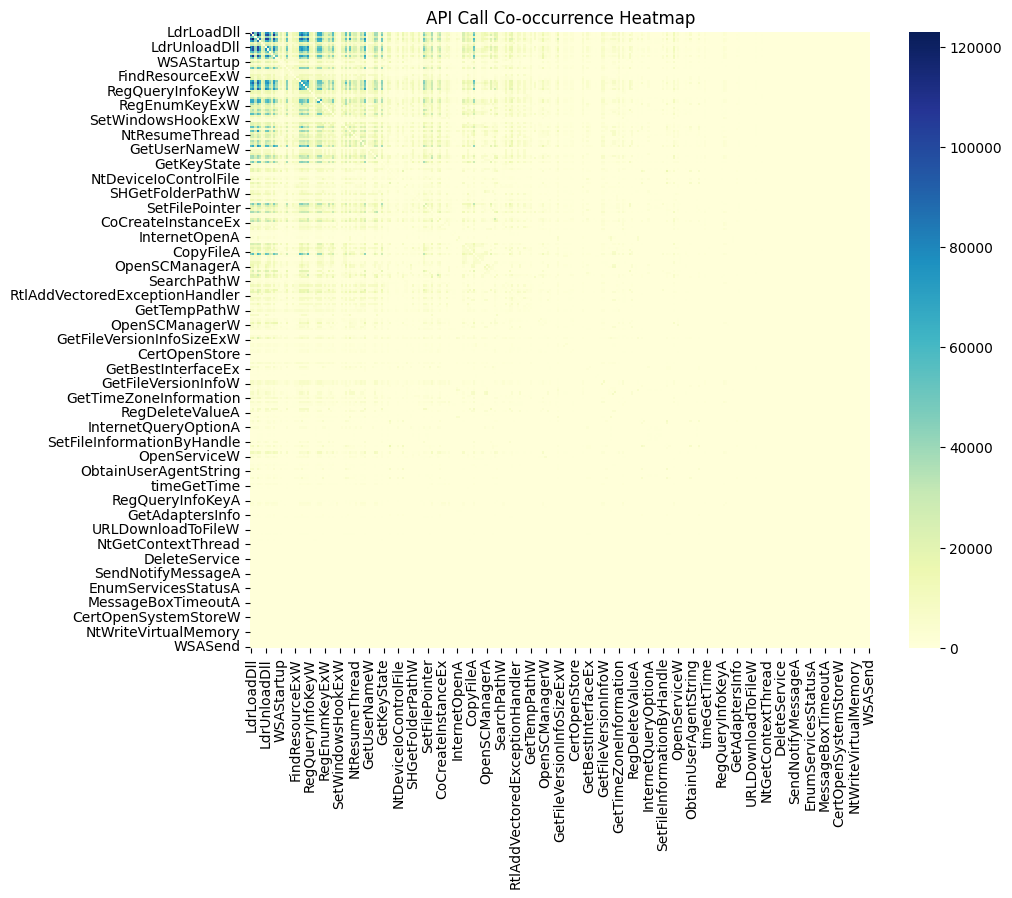

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=False, cmap='YlGnBu')
plt.title('API Call Co-occurrence Heatmap')
plt.show()